# 1- ETL - Maximum Possible Return on Equity
This is the first of multiple notebooks that are intended to address the objectives below.  This notebook:
1. performs the Extract, Transform, Load of source data from Kaggle
2. selects Tickers and intervals per criteria below
3. saves only qualified records to disk as pickle format time series alphabetically (similar to source organization).

Subsequent notebooks contain analysis and visualization.

__Primary Objective:__  
What is the maximum possible return that could be achieved trading the top performing NASDAQ and NYSE historical stocks from 02/01/2000 to 27/08/2024?

__Secondary Objectives:__
* explore 'return/bar' as a performance metric
* understand distributions and possible application of 'return/bar'

## Conditions
1. Equities, long only
2. Look-ahead bias
3. Diversification - hold 20 positions, each representing ~5% of portfolio (no other forms of diversification).
4. 100% invested, always
5. Trading Fees of \\$0.005 per share (Interactive Brokers)
6. Slippage of 0.005%
7. Holding period of at least 1 bar with no maximum period
8. Assume position can be liquidated at close of bar and new position opened at open of next bar
9. Equity must have sufficient transaction such that a \\$5000 purchase is <= 5% of the volume at  at the time of purchase and sale.  For example, a \\$1 dollar equity would require 5000 shares to form a \\$5000 position.  The equity must have a minimum volume of 5000/0.05 = 100000 shares.
10. Income tax is not considered
11. No leverage
12. No attempt to validate source data (ie., were stock splits accounted for correctly?, does this data match other sources?)

## Source
https://www.kaggle.com/datasets/sbgonenc96/2000-2024-stocks-data

## Reference
https://www.kaggle.com/code/sbgonenc96/stocks-timeanalysis

In [1]:
import kagglehub
import pandas as pd
import json
import pathlib
import pickle
import matplotlib.pyplot as plt
import tqdm
# load local modules
from config import *
from utils import *
%config Completer.use_jedi = False

c:\users\user\onedrive\stocks\research & reference\nb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Methodology
Filter to equities that meet minimum volume criteria.  Identify the top 30 positive percent change values for every interval measured from the 'open' to the 'close'.  Provide ordered list of ticker symbols for each interval, sorted descending by percent change.

This Method will drastically reduce the amount of data present by using only qualified ticker-interval combinations.  

### Position Logic
1. Are there equities for whom the return for the next interval is greater thana position with a higher return 

### Volume Qualification Parameters
Does the ticker meet minimum volume requirements?  On which timestamps? 

In [2]:
for k_, v_ in parameters.items():
    print("{:<35} {:<10}".format(k_, v_))
print('\n')

equity_starting                     100000    
size_position_pct                   0.05      
position_max_pct_of_volume          0.05      
size_position                       5000.0    
min_ticker_dollar_volume            100000.0  




### Locations

In [3]:
root_dataset = "sbgonenc96/2000-2024-stocks-data"
dir_dataset = pathlib.Path(kagglehub.config.DEFAULT_CACHE_FOLDER) / 'datasets' / root_dataset / 'versions/36'
#  should be 'C:/Users/user/.cache/kagglehub/datasets/sbgonenc96/2000-2024-stocks-data/versions/36'
assert dir_dataset.is_dir()
dir_dataset

WindowsPath('C:/Users/user/.cache/kagglehub/datasets/sbgonenc96/2000-2024-stocks-data/versions/36')

In [4]:
# local directory to hold processed output & more
dir_data = pathlib.Path.cwd() / 'data'
dir_data.mkdir(exist_ok=True)
assert dir_data.is_dir()

### Load Data
Obtain from Kaggle if this hasn't been done already, otherwise use data previously saved to disk.

In [5]:
# if dir_dataset already exists, assume no need to request dataset from Kaggle
if not dir_dataset.is_dir():
    # Download dataset - First time setup
    path = kagglehub.dataset_download(root_dataset)
    print("Path to dataset files:", path)
    dir_kaggle= pathlib.Path(path)
else:
    dir_kaggle= dir_dataset
assert dir_kaggle.is_dir()

#### Identify available files

In [6]:
files_json = [list(f_.glob('*.json')) for f_ in dir_dataset.glob('*')]
files_json = [x for xs in files_json for x in xs]
assert files_json[-1].is_file()
files_json[:3]

[WindowsPath('C:/Users/user/.cache/kagglehub/datasets/sbgonenc96/2000-2024-stocks-data/versions/36/A.json/A_merged.json'),
 WindowsPath('C:/Users/user/.cache/kagglehub/datasets/sbgonenc96/2000-2024-stocks-data/versions/36/B.json/B_merged.json'),
 WindowsPath('C:/Users/user/.cache/kagglehub/datasets/sbgonenc96/2000-2024-stocks-data/versions/36/C.json/C_merged.json')]

### Open Single File

In [7]:
# read a single file
with open(files_json[-1], "r") as f:
    data_json = json.load(f)
# type(data_json)

In [8]:
data_json[0].keys()

dict_keys(['ticker', 'queryCount', 'resultsCount', 'adjusted', 'results', 'status', 'request_id', 'count'])

In [9]:
ticker = data_json[0]['ticker']
col_rename = columns = {"c" : "close", "h":"high", "l": "low", "n":"n_transactions",
                        "o": "open", "t":"time", "v":"volume", "vw":"vwap"}
cols_use = ['volume', 'vwap', 'open', 'close', 'time']
df = pd.DataFrame.from_dict(data_json[0]['results']).rename(columns=col_rename)[cols_use]
df.head()

,volume,vwap,open,close,time
0,9547333,0.0001,0.0001,0.0002,1661866200000
1,5000000,0.0002,0.0002,0.0002,1661875200000
2,3820000,0.0001,0.0001,0.0002,1661887800000
3,350000,0.0002,0.0002,0.0002,1661954400000
4,700000,0.0001,0.0001,0.0002,1661959800000


In [10]:
df["time"] = pd.to_datetime(df["time"], unit="ms")
df = df.set_index("time")
df.tail()

,volume,vwap,open,close
time,,,,
2024-08-13 14:30:00,5000000,NaN,0.000001,0.000001
2024-08-20 13:30:00,4686,NaN,0.000001,0.000001
2024-08-22 16:30:00,900,0.0001,0.000050,0.000050
2024-08-23 15:30:00,1000000,0.0001,0.000050,0.000050
2024-08-23 18:00:00,500000,0.0001,0.000050,0.000050


In [11]:
df['vwap'].where(df['vwap'].isna(), df[['open', 'close']].mean(axis=1))

time
2022-08-30 13:30:00    0.00015
2022-08-30 16:00:00    0.00020
2022-08-30 19:30:00    0.00015
2022-08-31 14:00:00    0.00020
2022-08-31 15:30:00    0.00015
                        ...   
2024-08-13 14:30:00        NaN
2024-08-20 13:30:00        NaN
2024-08-22 16:30:00    0.00005
2024-08-23 15:30:00    0.00005
2024-08-23 18:00:00    0.00005
Name: vwap, Length: 874, dtype: float64

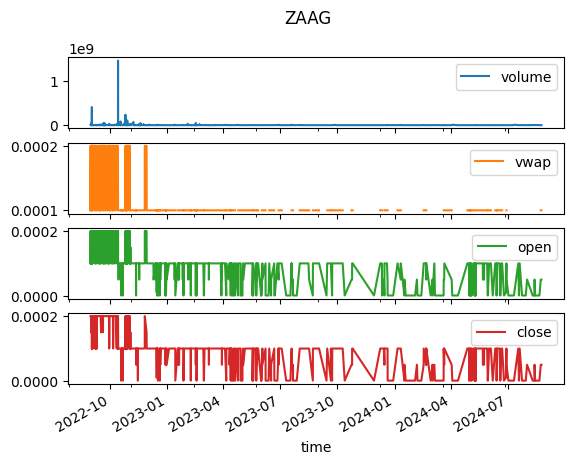

In [12]:
df.select_dtypes(exclude=[object]).plot(subplots=True, title=ticker)
plt.show()

### Example Ticker & Bar Qualification 

In [13]:
df['has_min_volume'] = (df['volume'] * df['vwap'] > 
                        parameters['min_ticker_dollar_volume'])
df['has_min_volume'] = df['has_min_volume'].astype(bool)

In [14]:
df.drop(columns = ['volume', 'vwap'], inplace=True)

In [15]:
df[['open', 'close', 'has_min_volume']]

,open,close,has_min_volume
time,,,
2022-08-30 13:30:00,0.000100,0.000200,False
2022-08-30 16:00:00,0.000200,0.000200,False
2022-08-30 19:30:00,0.000100,0.000200,False
2022-08-31 14:00:00,0.000200,0.000200,False
2022-08-31 15:30:00,0.000100,0.000200,False
...,...,...,...
2024-08-13 14:30:00,0.000001,0.000001,False
2024-08-20 13:30:00,0.000001,0.000001,False
2024-08-22 16:30:00,0.000050,0.000050,False


In [16]:
df['has_min_volume'].value_counts()

has_min_volume
False    873
True       1
Name: count, dtype: int64

In [17]:
df.loc[df['has_min_volume'], ['open', 'close']].pct_change(axis=1).iloc[:,-1]

time
2022-10-13 18:30:00    0.020408
Name: close, dtype: float64

In [18]:
dfs = {}
dfs[ticker] = df.loc[df['has_min_volume'], ['open', 'close']].pct_change(axis=1).iloc[:,-1]

In [19]:
dfs[ticker]

time
2022-10-13 18:30:00    0.020408
Name: close, dtype: float64

## Process All Files

In [20]:
col_rename = columns = {"c" : "close", "h":"high", "l": "low", "n":"n_transactions",
                                "o": "open", "t":"time", "v":"volume", "vw":"vwap"}
cols_use = ['volume', 'vwap', 'open', 'close', 'time']
cols_required = set(['c', 'o', 't', 'v'])
cols_checks = ['has_required_cols', 'has_min_volume',
               'has_qualified_records']
quality_checks = {}
# has_required_cols = {}
file_json_ = files_json[-1]

In [21]:
%%time
for file_json_ in tqdm.tqdm(files_json):
    dfs_ = {}
    list_of_jsons = read_json(file_json_)
    for json_ in list_of_jsons:
#         track quality checks
        checks_ = []
#         identify ticker name
        ticker = json_['ticker']
#         print(ticker)
#         check first ticker only for required columns
        has_required_cols_ = len(cols_required.difference(
                            json_['results'][0].keys())) == 0
        checks_.append(has_required_cols_)
#         has_vwap[ticker] = has_required_cols_
#         ignore tickers that do not have the expected columns
        if not has_required_cols_:
            pass
        elif has_required_cols_:
            df = pd.DataFrame.from_dict(json_['results']).rename(
                        columns=col_rename, errors='ignore')
            df = df[df.columns.intersection(cols_use)]
#             format timestamps & set as index
#             in the interest of memory efficiency, leave 'time' as an integer
#             df["time"] = pd.to_datetime(df["time"], unit="ms")
            df = df.set_index("time")
#             if 'vwap' is not provided, substitute the mean of 'open' and 'close'
            has_vwap_ = 'vwap' in df.columns
#             if vwap is provided, fill nan values as mean of 'open' and 'close'
            if has_vwap_:
                df['vwap'] = df['vwap'].mask(df['vwap'].isna(),
                             df[['open', 'close']].mean(axis=1))
            elif not has_vwap_:
                df['vwap'] = df[['open', 'close']].mean(axis=1)
#             when does ticker meet minimum volume criteria?
            df['has_min_volume'] = df['volume'] * df['vwap'] > parameters['min_ticker_dollar_volume']
            df['has_min_volume'] = df['has_min_volume'].astype(int)
            checks_.append(df['has_min_volume'].mean())
            has_qualified_records_ = df['has_min_volume'].eq(1).any()
            checks_.append(has_qualified_records_)
            if has_qualified_records_:
                df.drop(columns = ['volume', 'vwap'], inplace=True)
        #         df.loc[df['has_min_volume'], ['open', 'close']].pct_change(axis=1).iloc[:,-1]
                dfs_[ticker] = df.loc[df['has_min_volume'].astype(bool), ['open', 'close']]\
                                .pct_change(axis=1).iloc[:,-1]
#             if there are no qualified bars for ticker, ignore that ticker
            elif not has_qualified_records_:
                pass
        quality_checks[ticker] = checks_
    # Save dictionaries of time series to Pickle
    pickle_out_name_ = file_json_.name.replace('_merged.json', '_qualified.pkl')
    pickle_out_ = dir_data / pickle_out_name_
    with open(pickle_out_, 'wb') as f:
        pickle.dump(dfs_, f)
    assert pickle_out_.is_file()

100%|██████████████████████████████████████████████████████████████████████| 26/26 [04:06<00:00,  9.47s/it]

CPU times: total: 4min
Wall time: 4min 6s


### Test Opening of Output files 

In [22]:
files_qualified = list(dir_data.glob('*_qualified.pkl'))
files_qualified[:3]

[WindowsPath('C:/Users/user/OneDrive/STOCKS/Research & Reference/nb/max possible return on equity/src/data/A_qualified.pkl'),
 WindowsPath('C:/Users/user/OneDrive/STOCKS/Research & Reference/nb/max possible return on equity/src/data/B_qualified.pkl'),
 WindowsPath('C:/Users/user/OneDrive/STOCKS/Research & Reference/nb/max possible return on equity/src/data/C_qualified.pkl')]

In [23]:
# %%timeit
# Load from Pickle
df_pickle = read_pickle(files_qualified[0])
df_sparse = pd.concat(df_pickle, axis=1).astype(pd.SparseDtype("float"))
df_sparse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15487 entries, 1661779800000 to 1724232600000
Columns: 1196 entries, AABB to AZZ
dtypes: Sparse[float64, nan](1196)
memory usage: 17.6 MB


In [24]:
df_sparse.head()

,AABB,AACAY,AACG,AAC,AACI,AACIU,AACIW,AACT,AADI,AAFRF,...,AZO,AZPN,AZREF,AZRE,AZRMF,AZTA,AZTR,AZUL,AZYO,AZZ
time,,,,,,,,,,,,,,,,,,,,,
1661779800000,0.053105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026054,NaN,...,0.006121,0.00014,NaN,NaN,NaN,-0.00352,NaN,0.003891,NaN,NaN
1661866200000,0.022735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006372,NaN,...,0.000632,-0.00699,NaN,-0.101562,NaN,-0.018182,NaN,-0.040681,NaN,NaN
1662039000000,0.024308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0038,-0.007967,NaN,-0.038889,NaN,-0.016231,NaN,-0.019979,NaN,-0.002943
1662125400000,0.024194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022415,NaN,...,0.000205,0.005316,NaN,0.020173,NaN,-0.020841,NaN,-0.045643,NaN,NaN
1662127200000,0.039062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029235,NaN,...,-0.00047,0.00346,NaN,-0.002825,NaN,0.009299,NaN,0.025,NaN,NaN


<Axes: >

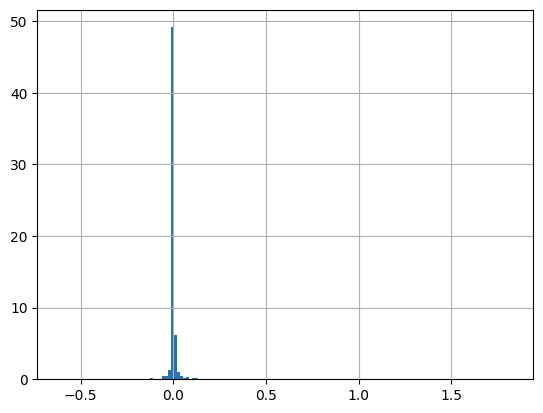

In [25]:
df_sparse.mean().hist(bins=150, density=True)

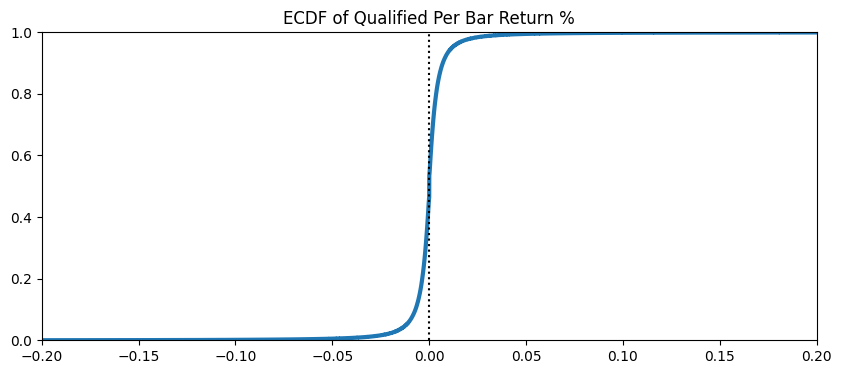

In [26]:
fig, ax = plt.subplots(figsize = (10,4))
ax.ecdf(df_sparse.stack().dropna().values, lw=3)
ax.set_xlim(-0.2, 0.2)
ax.axvline(0, color='black', linestyle=':')
ax.set_title('ECDF of Qualified Per Bar Return %')
plt.show()

### Review Quality Checks

In [27]:
df_checks = pd.DataFrame.from_dict(quality_checks, orient='index',
                                   columns=cols_checks)
# save df_checks to disk
file_checks = dir_data / 'quality_checks.csv'
df_checks.to_csv(file_checks)
assert file_checks.is_file()
print(file_checks)
df_checks.head()

C:\Users\user\OneDrive\STOCKS\Research & Reference\nb\max possible return on equity\src\data\quality_checks.csv


,has_required_cols,has_min_volume,has_qualified_records
AAALY,True,0.000000,False
AABB,True,0.027597,True
AABVF,True,0.000000,False
AACAF,True,0.000000,False
AACAY,True,0.026025,True


In [28]:
df_checks.mean()

has_required_cols        1.000000
has_min_volume           0.161288
has_qualified_records    0.562547
dtype: float64

#### How many Tickers have at least one qualified bar (interval)?

In [29]:
df_checks['has_qualified_records'].value_counts().to_frame(
    name='Count of Qualified Tickers')

,Count of Qualified Tickers
has_qualified_records,
True,12088
False,9400


#### How many Tickers meet Minimum Trading \\$ Volume Criteria?
..across available intervals

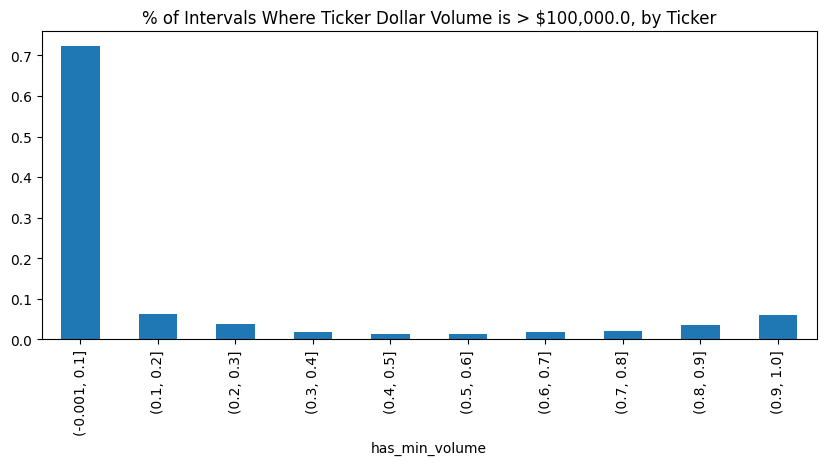

In [30]:
pd.cut(df_checks['has_min_volume'], bins=10).value_counts(normalize=True)\
    .sort_index().plot.bar(figsize=(10,4), 
       title=f'% of Intervals Where Ticker Dollar Volume is > ${parameters["min_ticker_dollar_volume"]:,}, by Ticker')
plt.show()

### Observations
* 12088 tickers have at least one qualified interval
* 9400 tickers do not have any qualified intervals
* There were roughly 12000 tickers over a ~20-year period that would be considered tradable per the minimum volume criteria. 
* More than 70% of tickers have less than \\$100,000 of 30-minute interval dollar volume for >90% of their history

# END Processing 

## Notes - Reference Only
Testing of saving and loading various data formats

In [31]:
%%timeit
# Load from Pickle
with open(files_qualified[0], 'rb') as f:
    df_pickle = pickle.load(f)

102 ms ± 687 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%%timeit
df_conv = pd.concat(df_pickle, axis=1)
# df_conv.info()

573 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
# %%timeit
# df_conv.iloc[:,:100].mean()

In [34]:
%%timeit
df_sparse = pd.concat(df_pickle, axis=1).astype(pd.SparseDtype("float"))
# df_sparse.info()

767 ms ± 9.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
# %%timeit
# df_sparse.iloc[:,:100].mean()

In [36]:
# import pandas as pd
import numpy as np
from scipy import sparse

# Create sample sparse time series data
n_periods = 100000
timestamps = pd.date_range('2023-01-01', periods=n_periods, freq='H')
timestamps = [1000 * int(x_.timestamp()) for x_ in timestamps]
data = np.random.rand(n_periods)
data[np.random.rand(n_periods) < 0.9] = 0  # Make it sparse

# Create a SparseDataFrame
sparse_df = pd.DataFrame({'timestamp': timestamps, 'value': data})\
                .astype({'value' : pd.SparseDtype("float", 0),
                         'timestamp': int})
sparse_df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_8784\628235894.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range('2023-01-01', periods=n_periods, freq='H')


,timestamp,value
0,1672531200000,0
1,1672534800000,0
2,1672538400000,0
3,1672542000000,0.902052
4,1672545600000,0


In [37]:
file_csv = 'delete_sparse_time_series.csv'

In [38]:
%%timeit
# Save to CSV

sparse_df.to_csv(file_csv, index=False)

97.9 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
df_csv = pd.read_csv(file_csv)

29.3 ms ± 622 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
file_pickle = 'sparse_time_series.pkl'

In [41]:
%%timeit
# Save to Pickle (fast serialization)

sparse_df.to_pickle(file_pickle)

719 µs ± 22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [42]:
%%timeit
df_pickle = pd.read_pickle(file_pickle)

428 µs ± 7.54 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
